# 교차검증 (K-Fold)

## #01. K-Fold 개요

### [1] 머신러닝을 구현하는 과정에서의 대표적 문제점

| 구분 | 설명 |
|---|---|
| 과대적합(Overfitting) | 학습 데이터를 과하게 학습하는 것 |
| 과소적합(Underfitting) | 학습 데이터를 충분히 학습하지 못하는 것 |
| Sample loss 문제 | 학습 데이터가 적은 경우 발생하는 문제<br/>데이터를 Train용과 Test용으로 나누는 과정에서 Train 데이터가 부족해지기 때 문에 발생하는 문제 |

위와 같은 상황에서 학습이 발생시키는 에러를 과소추정하지 않으면서 데이터의 손실
을 최소화하는 방법으로 K-폴드 교차 검증이 있다.

- 과적합을 방지한다.
- 데이터 편향을 방지한다.
- 일반화 된 모델을 생성할 수 있다.

### [2] `K`가 5인 경우에 대한 K-폴드 교차 검증 예시

![img](res/grid_search_cross_validation.png)

하나의 데이터 셋을 5등분하여 각 Fold마다 한 번씩 Test 데이터가 되도록
train_split을 개별 수행한다.

그 결과 총 5번의 학습이 가능해지며 그 학습 결과에 대한 평균치를 구한다.

## #01. 준비작업

### [1] 패키지 참조

In [1]:
import sys
import os
work_path = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(work_path)

from helper.regrassion import *
from helper.util import *
from helper.plot import *
from helper.analysis import *

# 선형회귀분석 모듈
from sklearn.linear_model import LinearRegression

# K-Fold
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict

### [2] 데이터 가져오기

In [2]:
origin = my_read_excel("https://data.hossam.kr/mldata/fish.xlsx", info=False)
my_pretty_table(origin.head())

+----+--------+--------+--------+--------+
|    |   길이 |   높이 |   두께 |   무게 |
|----+--------+--------+--------+--------|
|  0 |    8.4 |   2.11 |   1.41 |    5.9 |
|  1 |   13.7 |   3.53 |      2 |     32 |
|  2 |     15 |   3.82 |   2.43 |     40 |
|  3 |   16.2 |   4.59 |   2.63 |   51.5 |
|  4 |   17.4 |   4.59 |   2.94 |     70 |
+----+--------+--------+--------+--------+


## #03. 데이터 전처리

### [1] 독립변수, 종속변수 분리

In [3]:
yname = '무게'
x = origin.drop(yname, axis=1)
y = origin[yname]
x.shape, y.shape

((56, 3), (56,))

## #04. K-Fold 교차 검증을 적용한 회귀 모델

### [1] 한가지 평가지표만 확인하기

1개의 폴드부터 10개의 폴드 까지 반복적으로 수행

In [4]:
# 최대 폴드 수
k = 10

# 선형회귀분석 모델
model = LinearRegression(n_jobs=-1)

# 각 폴드별 R2
scores = cross_val_score(model, x, y, cv=k, scoring='r2', n_jobs=-1)

print("R2: ", scores)
print("R2 최대값: ", scores.max())
print("R2 최대값의 Fold수: ", scores.argmax()+1)

R2:  [-5.80130229e+01 -2.31476956e+00 -4.52072266e+01 -4.47723355e+00
 -5.35954360e+00 -1.75520025e+01  6.25492054e-01  5.30196516e-01
 -5.03267727e-02 -1.75845285e+01]
R2 최대값:  0.62549205419385
R2 최대값의 Fold수:  7


### [2] 전체 정보 얻기

#### (1) K-Fold 수행

리턴받고자 하는 정보를 bool 형식으로 설정

In [5]:
model = LinearRegression(n_jobs=-1)
result = cross_validate(model, x, y, cv=k, 
                        return_train_score=True, return_estimator=True, 
                        n_jobs=-1) 
result_df = DataFrame(result)
my_pretty_table(result_df)

+----+-------------+--------------+-----------------------------+--------------+---------------+
|    |    fit_time |   score_time | estimator                   |   test_score |   train_score |
|----+-------------+--------------+-----------------------------+--------------+---------------|
|  0 |           0 |    0.0156231 | LinearRegression(n_jobs=-1) |      -58.013 |      0.969328 |
|  1 |           0 |    0.0159843 | LinearRegression(n_jobs=-1) |     -2.31477 |       0.93761 |
|  2 |           0 |    0.0159843 | LinearRegression(n_jobs=-1) |     -45.2072 |      0.939373 |
|  3 |   0.0156231 |   0.00136137 | LinearRegression(n_jobs=-1) |     -4.47723 |      0.940413 |
|  4 |   0.0159843 |   0.00100017 | LinearRegression(n_jobs=-1) |     -5.35954 |      0.943642 |
|  5 |   0.0186782 |   0.00266194 | LinearRegression(n_jobs=-1) |      -17.552 |      0.948462 |
|  6 |  0.00134611 |   0.00281119 | LinearRegression(n_jobs=-1) |     0.625492 |      0.945635 |
|  7 |  0.00134611 |   0.00281

#### (2) 최적의 성능을 갖는 폴드에 대한 학습 객체 추출

In [6]:
maxindex = result_df['test_score'].argmax()
best_model = result_df.iloc[maxindex]['estimator']
best_model

LinearRegression(n_jobs=-1)

### [3] 최적의 k폴드 수행에 대한 추정치 얻기

In [7]:
y_predict = cross_val_predict(model, x, y, cv=maxindex+1, n_jobs=-1)
y_predict

array([-415.07853167, -226.51199473, -170.5319201 , -102.50092462,
        -68.04456227,   -9.39059305,   -7.16198571,   16.88762632,
         63.61423719,   41.92835141,  139.71780356,  139.54040268,
        147.04399414,  187.58426947,  161.29346999,  134.95737725,
        171.75681189,  155.22220036,  160.06735997,  161.06534327,
        227.92268556,  168.52744392,  116.5759082 ,  199.41972277,
        276.25603007,  221.46559183,  269.52394449,  219.52200383,
        265.68650727,  303.05013887,  447.64446312,  319.07001843,
        312.17502048,  343.23703929,  353.00323619,  372.34359822,
        388.28133524,  641.13625561,  688.40093468,  869.19466922,
        759.52498486,  729.72075358,  728.31303342,  709.7854361 ,
        814.30380312,  744.33044163,  920.9310011 ,  866.73418149,
        754.01238957,  813.11997327,  655.80233646,  749.79587392,
        752.08029315,  795.94389038,  883.27908607,  810.40730325])

## #05. 도출된 모델을 통한 회귀분석 결과 확인

### [1] 성능평가

[회귀분석 성능평가]
+--------+----------------+---------------------+---------------------+------------------+---------------------------------+-----------------------+
|        |   결정계수(R2) |   평균절대오차(MAE) |   평균제곱오차(MSE) |   평균오차(RMSE) |   평균 절대 백분오차 비율(MAPE) |   평균 비율 오차(MPE) |
|--------+----------------+---------------------+---------------------+------------------+---------------------------------+-----------------------|
| 데이터 |       0.940166 |             64.9312 |             7101.14 |          84.2683 |                         122.858 |               92.1434 |
+--------+----------------+---------------------+---------------------+------------------+---------------------------------+-----------------------+

[선형회귀분석 결과보고]
+----+------------+------------+--------------------+------------+------------------+--------+------------+---------+
|    | 종속변수   | 독립변수   |   B(비표준화 계수) |   표준오차 |   β(표준화 계수) |      t |   유의확률 |     VIF |
|----+------------+------------+--------------------+-----

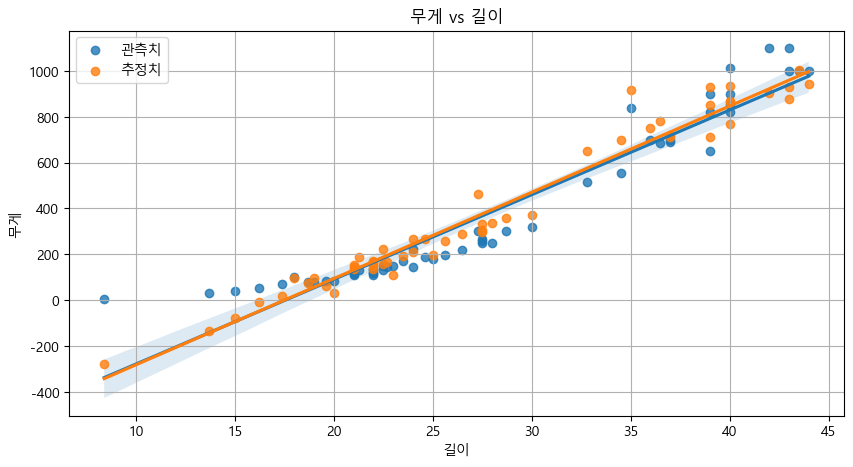

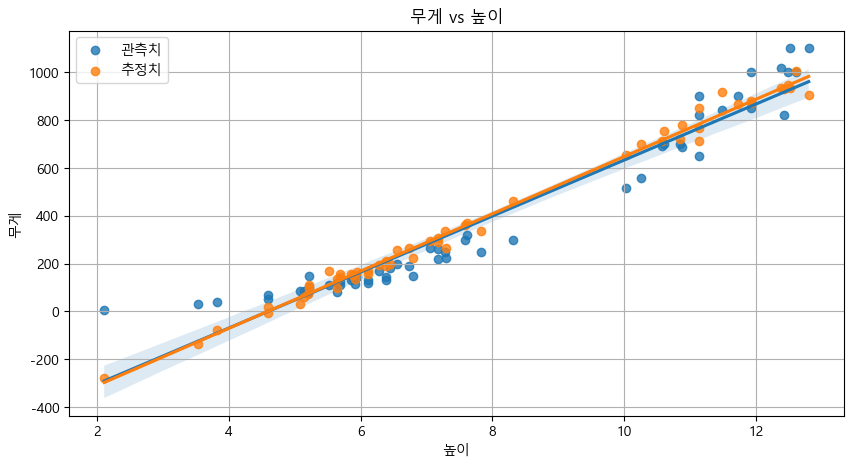

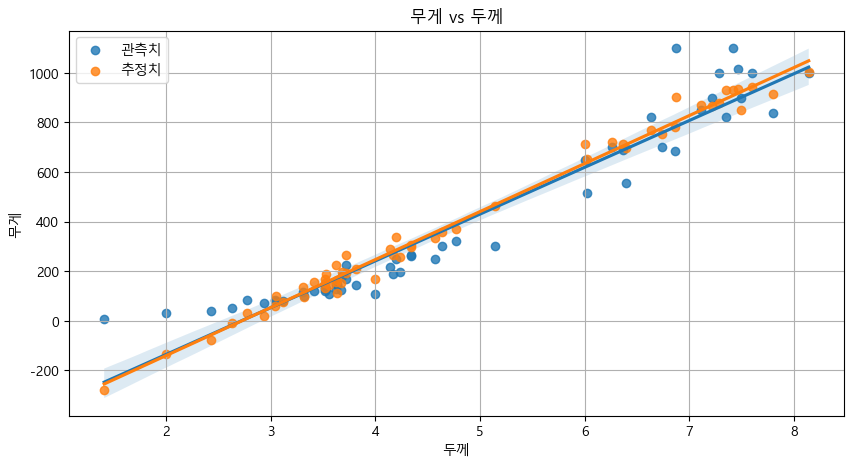

In [ ]:
my_linear_regrassion_result(best_model, x, y, dpi=100)

### [2] 독립변수 보고

In [ ]:
my_linear_regrassion_report(best_model, x, y)

[선형회귀분석 결과보고]
+----+------------+------------+--------------------+------------+------------------+--------+------------+---------+
|    | 종속변수   | 독립변수   |   B(비표준화 계수) |   표준오차 |   β(표준화 계수) |      t |   유의확률 |     VIF |
|----+------------+------------+--------------------+------------+------------------+--------+------------+---------|
|  0 | 무게       | 길이       |            -2.8122 |      7.876 |            0.075 | -0.357 |      0.722 | 230.196 |
|  1 | 무게       | 높이       |            71.8354 |     29.987 |            0.556 |  2.396 |       0.02 | 413.582 |
|  2 | 무게       | 두께       |            93.0928 |     36.672 |            0.343 |  2.539 |      0.014 | 247.585 |
+----+------------+------------+--------------------+------------+------------------+--------+------------+---------+

𝑅^2(0.940), Adj.𝑅^2(0.937), F(272.356), P-value(1.11e-16), Durbin-Watson(0.490)

무게에 대하여 길이,높이,두께로 예측하는 회귀분석을 실시한 결과,
이 회귀모형은 통계적으로 유의하다(F(3,52) = 272.356, p <= 0.05).

길이의 회귀계수는 -2.812(p > 0.05)로, 

### [3] 잔차검정

[잔차의 선형성 가정]


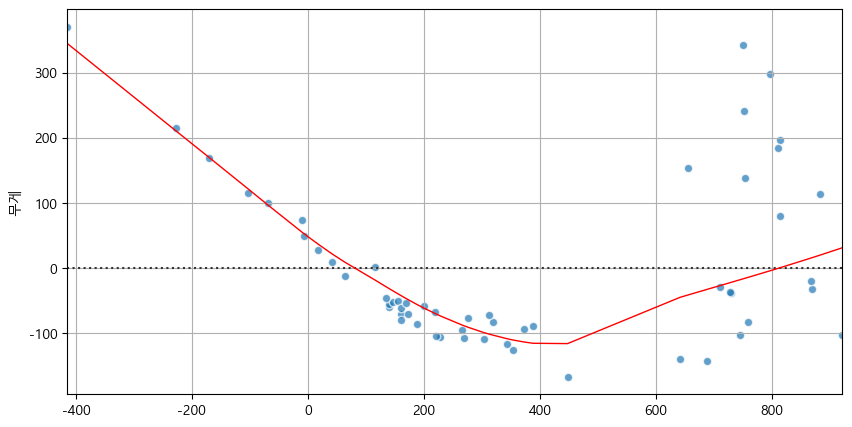


[잔차의 정규성 가정]


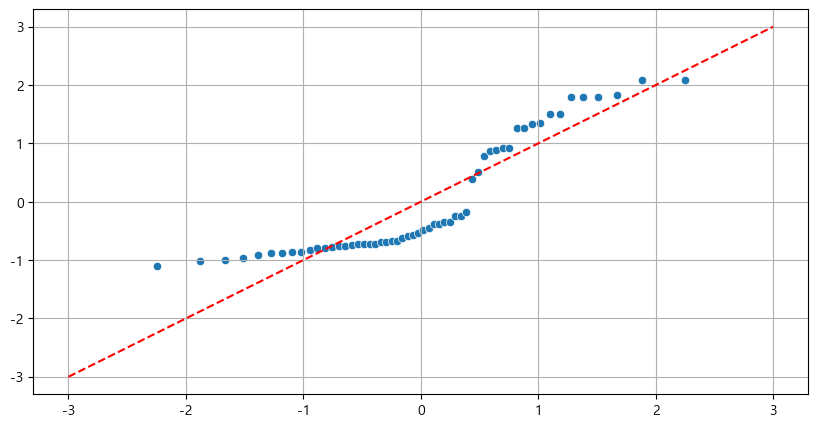

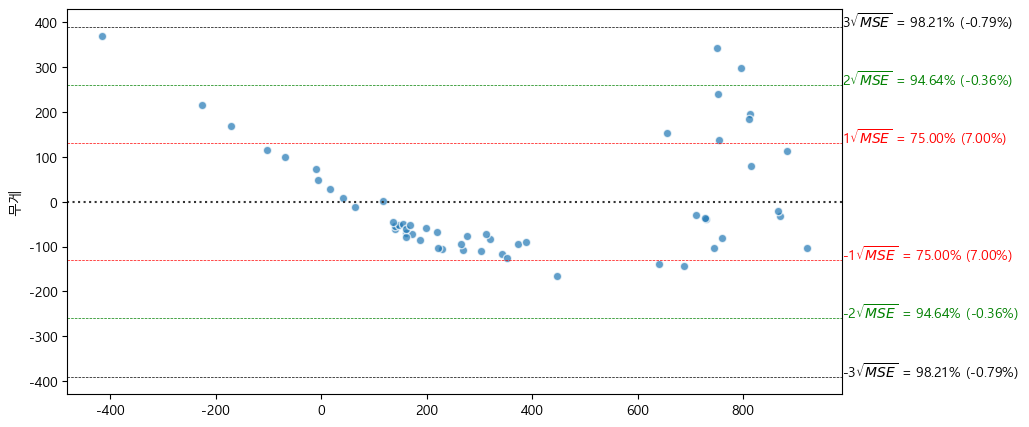

루트 1MSE 구간에 포함된 잔차 비율: 75.00% (7.0)
루트 2MSE 구간에 포함된 잔차 비율: 94.64% (-0.3571428571428612)
루트 3MSE 구간에 포함된 잔차 비율: 98.21% (-0.7857142857142918)
잔차의 정규성 가정 충족 여부: False

[잔차의 등분산성 가정]
잔차의 등분산성 가정 충족 여부: True
+-----------+----------+
|           |   values |
|-----------+----------|
| statistic |  2.11146 |
| p-value   | 0.549597 |
| f-value   | 0.679156 |
| f p-value | 0.568768 |
+-----------+----------+

[잔차의 독립성 가정]
Durbin-Watson: 0.2810292685974457, 잔차의 독립성 가정 만족 여부: False


In [ ]:
my_resid_test(x, y, y_predict, dpi=100)